In [1]:
%autosave 0

Autosave disabled


# Utility Functions

## Date Handling

In [2]:
import datetime

DESIRED_DATE_FORMAT = "%Y-%m-%d"

'''
Converts a timestamp (represented as a string) in one date format into another date format. Returns
the newly formatted date as a string.

A list of acceptable date format characters can be found at the following link.
https://docs.python.org/2/library/datetime.html#strftime-and-strptime-behavior
'''
def convertTimestamp(timestamp, initialFormat, desiredFormat):
    return datetime.datetime.strptime(timestamp, initialFormat).strftime(desiredFormat)

## Graphing

### Gauge

In [3]:
%matplotlib notebook
import os, sys
import matplotlib
from matplotlib import cm
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.patches import Circle, Wedge, Rectangle

ARROW_TAIL_RADIUS = 0.015

# Determines the range of angles which represent each portion of a gauge with n items.
def degreeRange(n): 
    start = np.linspace(0,180,n+1, endpoint=True)[0:-1]
    end = np.linspace(0,180,n+1, endpoint=True)[1::]
    mid_points = (start + end)/2.0
    return np.c_[start, end], mid_points

# Rotates a piece of text by a given angle.
def rot_text(ang): 
    rotation = np.degrees(np.radians(ang) * np.pi / np.pi - np.radians(90))
    return rotation

# Linearly maps a value within one range to a new range.
def map(num, init_min, init_max, new_min, new_max):
    return (num - init_min) * (new_max - new_min) / (init_max - init_min) + new_min

class Gauge:
    def __init__(self, labels, colors, currentVal, minVal, maxVal, title='', displayGauge=True):
        self.labels = labels
        self.colors = colors
        self.currentVal = currentVal
        self.minVal = minVal
        self.maxVal = maxVal
        self.title = title
        
        if displayGauge:
            self.fig, self.ax, self.arrow = self.generateGauge()
        
    '''
    Creates and displays a gauge. Returns a tuple containing the generated figure, axes,
    and arrow.
    '''
    def generateGauge(self):
        N = len(self.labels)

        if isinstance(self.colors, list): 
            self.colors = self.colors[::-1]

        """
        begins the plotting
        """

        fig, ax = plt.subplots()

        ang_range, mid_points = degreeRange(N)

        self.labels = self.labels[::-1]

        """
        plots the sectors and the arcs
        """
        patches = []
        for ang, c in zip(ang_range, self.colors): 
            # sectors
            patches.append(Wedge((0.,0.), .4, *ang, facecolor='w', lw=2))
            # arcs
            patches.append(Wedge((0.,0.), .4, *ang, width=0.10, facecolor=c, lw=2, alpha=0.5))

        [ax.add_patch(p) for p in patches]


        """
        set the labels (e.g. 'LOW','MEDIUM',...)
        """

        for mid, lab in zip(mid_points, self.labels):
            AVG_STR_LENGTH = 12
            AVG_FONT_SIZE = 11
            MAX_FONT_SIZE = 30

            fontSize = min(AVG_STR_LENGTH / len(lab) * AVG_FONT_SIZE, MAX_FONT_SIZE) # create dynamic font size based on string length
            ax.text(0.35 * np.cos(np.radians(mid)), 0.35 * np.sin(np.radians(mid)), lab,
                horizontalalignment='center', verticalalignment='center', fontsize=fontSize,
                fontweight='bold', rotation = rot_text(mid))

        """
        set the bottom banner and the title
        """
        r = Rectangle((-0.4,-0.1),0.8,0.1, facecolor='w', lw=2)
        ax.add_patch(r)

        ax.text(0, -0.05, self.title, horizontalalignment='center',
             verticalalignment='center', fontsize=22, fontweight='bold')

        #Plot the arrow based on given sentiment value.
        lowestAngle = ang_range[0][0]
        highestAngle = ang_range[-1][1]

        pos = map(self.currentVal, self.minVal, self.maxVal, highestAngle, lowestAngle)

        arrow = ax.arrow(0, 0, 0.225 * np.cos(np.radians(pos)), 0.225 * np.sin(np.radians(pos)),
                     width=0.03, head_width=0.09, head_length=0.1, fc='k', ec='k')
        #arrow.remove()

        ax.add_patch(Circle((0, 0), radius=ARROW_TAIL_RADIUS, facecolor='k')) # make the arrow rounded at the tail

        """
        removes frame and ticks, and makes axis equal and tight
        """

        ax.set_frame_on(False)
        ax.axes.set_xticks([])
        ax.axes.set_yticks([])
        ax.axis('equal')
        plt.tight_layout()
        
        return (fig, ax, arrow)

# Generates a gauge with options "Low", "Medium", and "High".
def displayNeutralGauge(currentVal, minVal, maxVal, title):
    return Gauge(labels=["Low", "Medium", "High"], colors=['#c80000','#646400','#00c800'], currentVal=currentVal,
                 minVal=minVal, maxVal=maxVal, title=title)

### Time-Series

In [4]:
class TimeSeries:
    def __init__(self, fig=None, ax=None):
        self.fig = fig
        self.ax = ax

'''
Plots an easily modifiable time series. 

The data is provided in xyDict, where each key (string) represents the type of value stored (like 'price' or 'sentiment')
and the corresponding value is a dictionary containing two keys: 'x' and 'y'. 'x' points to a list of the x-values of all
the desired points (must be in a date format) and 'y' points to a list of the y-values of the desired points. The first key in the dictionary is
the only data that can be modified.

dateFormat (string) represents the format of all the incoming x-values. graphDateFormat (string) represents the format in which the given
dates will be displayed on the x-axis. 

If seeking to modify an existing graph, existingGraph represents the TimeSeries which was already produced by this function.
'''
def plotTimeSeries(xyDict, title="",dateFormat="%Y-%m-%dT%H:%M:%S.%fZ", graphDateFormat="%Y", existingGraph=None, 
                   yMin=None, yMax=None):
    if existingGraph == None:
        fig, ax = plt.subplots()
    else:
        fig, ax = existingGraph.fig, existingGraph.ax
    
    colors = ['tab:red', 'tab:blue', 'tab:green']
    i = 0
    for valueType, xyVals in xyDict.items():
        formattedDates = []
        for date in xyVals['x']:
            if not isinstance(date, datetime.datetime):
                formattedDates += [datetime.datetime.strptime(date, dateFormat)]
            else:
                formattedDates += [date]
            
        dates = matplotlib.dates.date2num(formattedDates)

        if i == 0:
            desiredAxes = ax
        else:
            desiredAxes = ax.twinx()
            
        desiredAxes.set_ylabel(valueType, color=colors[i])
        desiredAxes.plot(formattedDates, xyVals['y'], color = colors[i])
        desiredAxes.set_title(title)
        desiredAxes.xaxis.set_major_formatter(matplotlib.dates.DateFormatter(graphDateFormat))
        
        if yMin != None:
            ax.set_ylim(ymin=yMin)
        if yMax != None:
            ax.set_ylim(ymax=yMax)
            
        i += 1
    fig.tight_layout()
    
    return TimeSeries(fig, ax)

# Sentiment Analysis

## Start the NLP server


In [21]:
import os

STANFORD_NLP_LOCATION = '~/stanford-corenlp-full-2018-10-05/' # the location of the Stanford NLP library on my computer 
                                                              #(download at https://stanfordnlp.github.io/CoreNLP)
STANFORD_NLP_TIMEOUT = 100000 # the time after which a given NLP request will be killed if not yet complete
STANFORD_NLP_PORT = 9002

os.popen('cd {}; java -mx5g -cp "*" edu.stanford.nlp.pipeline.StanfordCoreNLPServer -timeout {} -port {}'.format(
        STANFORD_NLP_LOCATION, STANFORD_NLP_TIMEOUT, STANFORD_NLP_PORT)) 

## Create function to determine the sentiment of a block of text

In [22]:
from pycorenlp import StanfordCoreNLP
import numpy

MIN_SENTIMENT = 0
MAX_SENTIMENT = 4

# Determines the sentiment of a given block of text as a range from 0 (Extremely Negative) to 4 (Extremely Positive).
def findSentiment(text):
    NLP_SERVER_LOCATION = 'http://localhost:{}'.format(STANFORD_NLP_PORT)
    PROPERTIES_DICTIONARY = {'annotators': 'sentiment', 'outputFormat': 'json', 'timeout': STANFORD_NLP_TIMEOUT}
    
    nlp = StanfordCoreNLP(NLP_SERVER_LOCATION)
    result = nlp.annotate(text, properties = PROPERTIES_DICTIONARY)

    sentiments = []
    for sentenceAnalysis in result['sentences']:
        sentimentValue = float(sentenceAnalysis['sentimentValue'])
        sentiments += [sentimentValue]
    return numpy.average(sentiments)

## Create function to compute and display sentiment value

In [7]:
# Displays a sentiment value (0-4) in a convenient gauge format.
def displaySentimentNum(sentimentVal):
    return Gauge(labels=['Very Negative','Negative','Neutral','Positive', 'Very Positive'], 
      colors=['#c80000','#c84b00','#646400','#64a000', '#00c800'], currentVal=sentimentVal, minVal = MIN_SENTIMENT, maxVal = MAX_SENTIMENT, title='Cryptocurrency Sentiment')

# Computes the sentiment value of a given piece of text and displays it as a gauge.
def displaySentimentTxt(text):
    return displaySentimentNum(findSentiment(text))    

## Scrape web for news article

The cryptocurrency has risen 148% in 2019. Many investors are betting on more growth ahead. As JPMorgan (JPM), Fidelity and the New York Stock Exchange get into the cryptocurrency business, investors have grown to trust bitcoin more as an asset for growth in their portfolios, says Kirill Bensonoff, CEO of OpenLTV, a platform which offers cryptocurrency and fiat loans for real estate debt. But as the price continues to rise,  we may see more corrections ahead,  Bensonoff said.Some bitcoin watchers anticipate the price could exceed $13,500 this year — eventually hitting an all-time high of $30,000 this year, bets Jehan Chu, co-founder and managing partner at Kenetic, a blockchain platform. Chu owns bitcoin and has repeatedly told media he anticipates bitcoin will rise to $30,000 in between steep rises and valleys. He said that low supply and increased demand, plus potential investment from established companies like Google and Apple, will fuel a price upswing.But others remain skeptical 

<IPython.core.display.Javascript object>


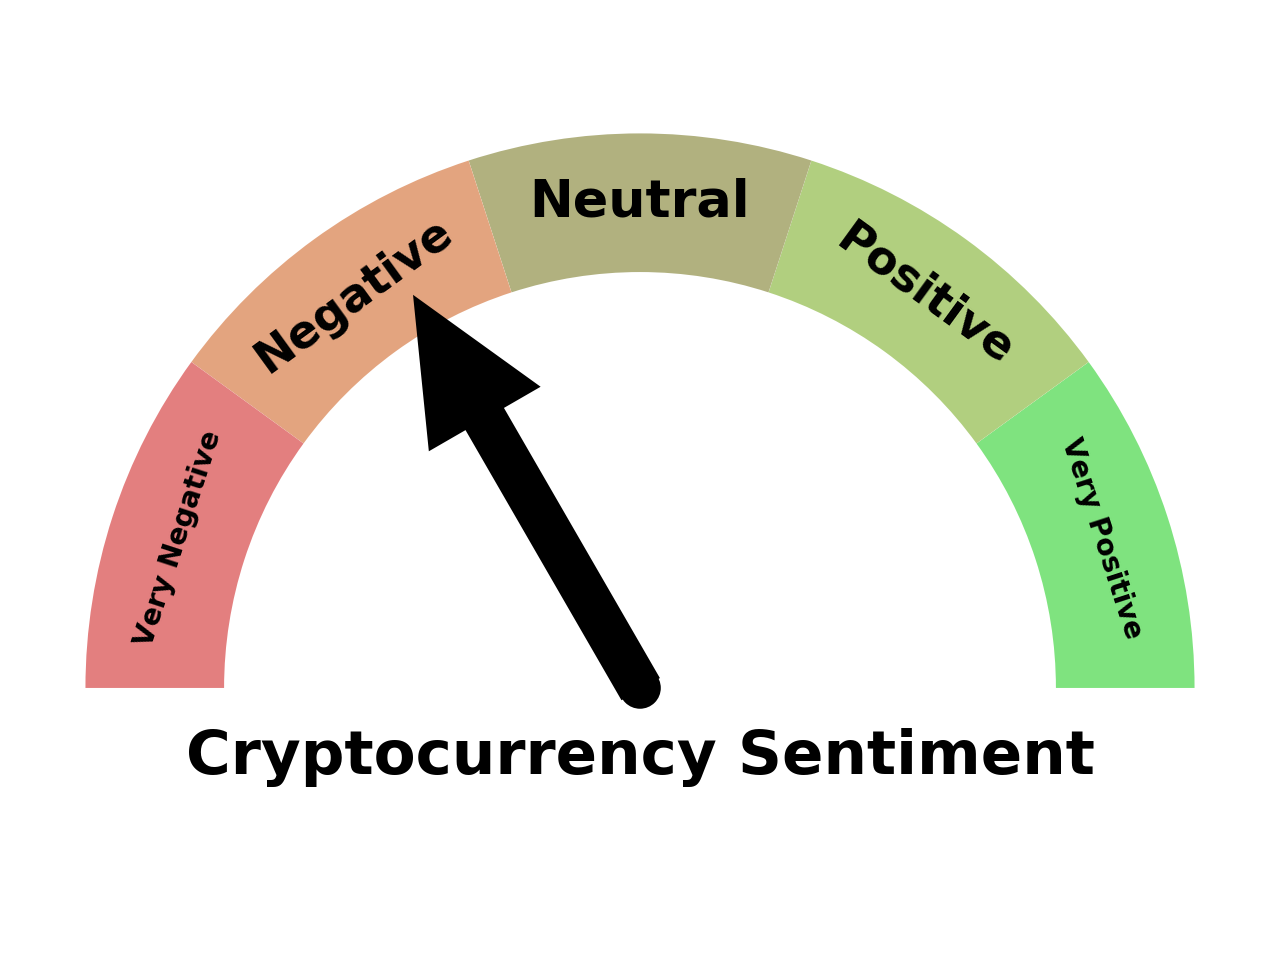

In [8]:
from requests import get
from requests.exceptions import RequestException
from contextlib import closing
from bs4 import BeautifulSoup
from newsapi import NewsApiClient

# Extracts the content located at any URL.
def getPageContent(url):
    try: 
        with closing(get(url, stream = True)) as page:
            return page.content.decode("utf-8")
    except RequestException as e:
        print(e)
        return
    
# Parses a string representing HTML, returning the parsed result for convenient iteration.
def parseHTML(url):
    return BeautifulSoup(getPageContent(url), 'html.parser')

# Extracts the text from a CNN article with given URL, excluding the headline and any advertisements.
def getCNNText(url):
    htmlParser = parseHTML(url)
    
    text = ''

    for element in htmlParser.select('div'):
        if element.has_attr('class') and 'zn-body__paragraph' in element['class']: 
            text += element.text 
    text = text.replace('"', ' ')
    return text
text = getCNNText("https://www.cnn.com/2019/06/17/investing/bitcoin-9300-trnd/index.html")
print(text)
displaySentimentTxt(text)

# Uses NewsAPI to extract all articles from a given day.
def getArticleURLs(day, month, year):
    dayPrefix = "%04d-%02d-%02d" % (year, month, day)
    
    newsapi = NewsApiClient(api_key = '8d99d69a251a453f8c084f4768db7195')
    
    urls = []
    second = 0
    minute = 0
    for hour in range (0, 24):
        for minute in range (0, 59, 10):
            iso8601DateStart = "%sT%s" % (dayPrefix, "%02d:%02d:%02d" % (hour, minute, second))
            iso8601DateEnd = "%sT%s" % (dayPrefix, "%02d:%02d:%02d" % (hour, minute + (10 if minute != 50 else 9), second))
            all_articles = newsapi.get_everything(q='bitcoin', from_param= iso8601DateStart, to=iso8601DateEnd, page=1)
            for article in all_articles['articles']:
                urls += article['url']
    return urls

## Create functions to retrieve and display Fear and Greed Index from any given date

<IPython.core.display.Javascript object>


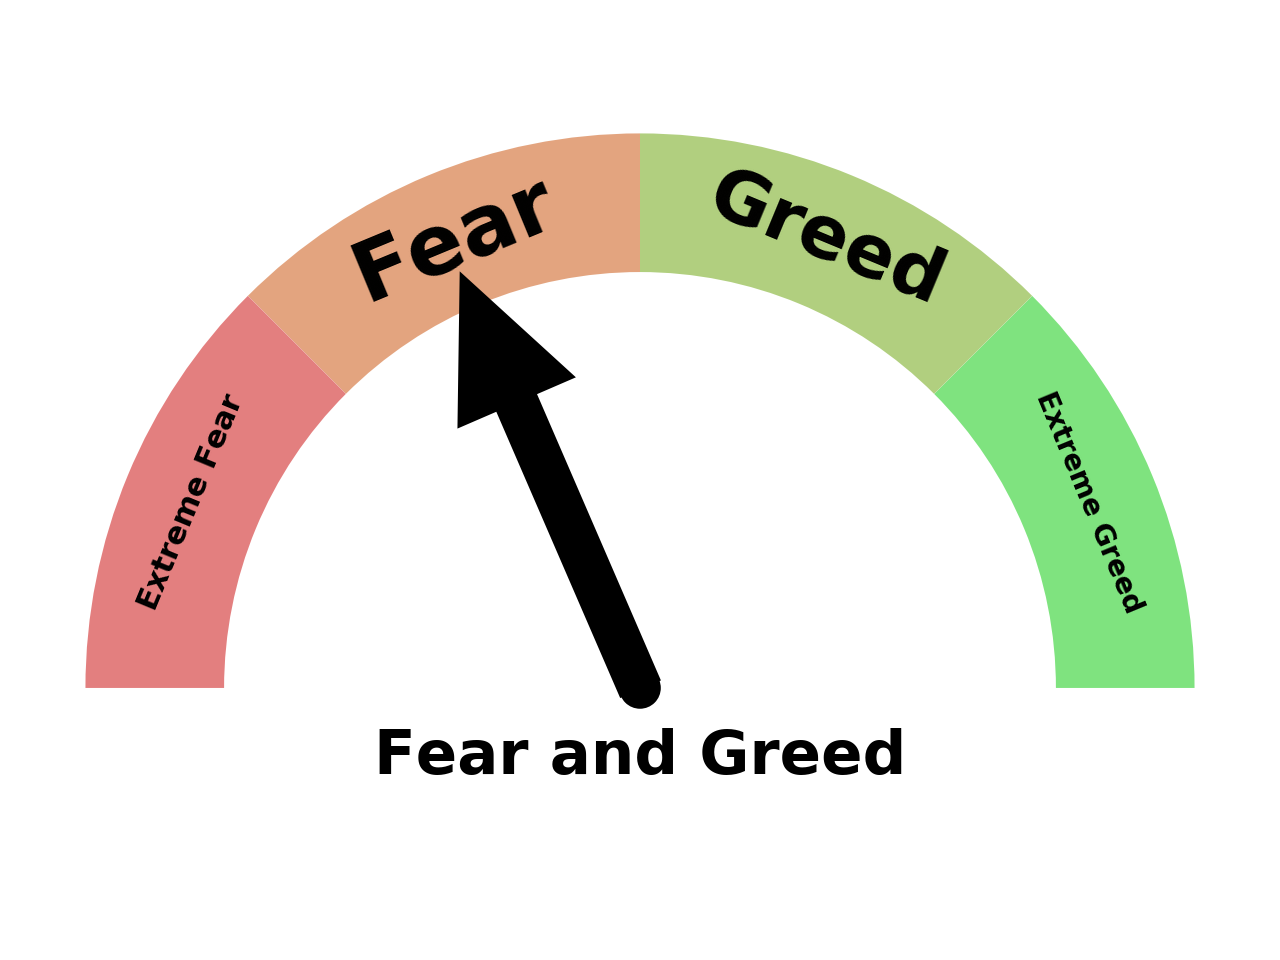

In [9]:
import json
import datetime

FEAR_AND_GREED_ADDRESS = "https://api.alternative.me/fng/?limit=0&date_format=us"
    
MIN_FEAR_AND_GREED = 0
MAX_FEAR_AND_GREED = 100

# Uses the Fear and Greed API to extract the Fear and Greed value from any given date.
def getFearAndGreed(date):
    timestampFormatted = date.strftime(DESIRED_DATE_FORMAT) 
    
    return getAllFearAndGreed()[timestampFormatted]
   
'''
Uses the Fear and Greed API to extract all Fear and Greed values available. Returns a dictionary with key as date
and value the Fear and Greed value on that date.
'''
def getAllFearAndGreed():
    fearAndGreedVals = getPageContent(FEAR_AND_GREED_ADDRESS)
    jsonUnpacked = json.loads(fearAndGreedVals)
    dataArr = jsonUnpacked['data']
    dataDict = {}
    for singleDay in dataArr:
        timestampFormatted = convertTimestamp(singleDay['timestamp'], '%m-%d-%Y', DESIRED_DATE_FORMAT)
        dataDict[timestampFormatted] = int(singleDay['value'])
        
    return dataDict

# Displays a given Fear and Greed value (0-100) in a convenient gauge format.
def displayFearAndGreedNum(val):
    return Gauge(labels=['Extreme Fear','Fear','Greed','Extreme Greed'], 
      colors=['#c80000','#c84b00','#64a000', '#00c800'], currentVal=val, minVal = MIN_FEAR_AND_GREED,
                 maxVal = MAX_FEAR_AND_GREED, title='Fear and Greed')

# Displays the Fear and Greed value from a given date in a convenient gauge format.
def displayFearAndGreedDate(date):
    return displayFearAndGreedNum(getFearAndGreed(date))

displayFearAndGreedDate(datetime.datetime(2018, 7, 10))

## Retrieve Google Trends data

In [28]:
from pytrends.request import TrendReq
import datetime

trends = TrendReq(hl='en-US', tz=0) # tz is timezone offset from UTC in minutes

'''
From trends.google.com: 

Numbers represent search interest relative to the highest point on the chart for the given region and time. 
A value of 100 is the peak popularity for the term. 
A value of 50 means that the term is half as popular. 
A score of 0 means there was not enough data for this term.
'''
def getTrendsData(keyword, startDate, endDate):
    trend = trends.get_historical_interest([keyword], 
                                               year_start=startDate.year, month_start=startDate.month, 
                                               day_start=startDate.day, hour_start=startDate.hour, 
                                               year_end=endDate.year, month_end=endDate.month, 
                                               day_end=endDate.day, hour_end=endDate.hour, 
                                               cat=0, geo='', gprop='', sleep=0)

    return trend[keyword]

'''
Determines the average trending data for a given keyword on each day within a given range of dates.
Because the Trends API posts multiple values per day, averages each of these results to find a single result
per day.

Returns a dictionary with key as date and value the trends data on that date.
'''
def getTrendsDataByDay(keyword, startDate, endDate):
    trendsData = getTrendsData(keyword, startDate, endDate)
 
    dateDict = {}
    for date, value in trendsData.items():
        dateString = date.strftime("%Y-%m-%d")
        if not dateString in dateDict:
            dateDict[dateString] = [value]
        else:
            dateDict[dateString] += [value]
            
    return {date:numpy.average(vals) for date, vals in dateDict.items()}

# Determines the Google trends data on a given date.
def getTrendsDataDate(keyword, date):
    startDate = datetime.datetime(year=date.year, month=date.month, day=date.day)
    trendsData = getTrendsData(keyword, startDate, startDate + datetime.timedelta(days=1))
    
    
    return numpy.average(trendsData)
    
bitcoinTrends = getTrendsDataByDay('Bitcoin', datetime.datetime(2019, 7, 1), datetime.datetime(2019, 7, 10))
print(bitcoinTrends)
#plotTimeSeries({"Trends": bitcoinTrends}, dateFormat="%Y-%m-%d %H:%M:%S", graphDateFormat="%H:%m")

{'2019-07-01': 83.08333333333333, '2019-07-02': 84.54166666666667, '2019-07-03': 78.16666666666667, '2019-07-04': 71.375, '2019-07-05': 67.25, '2019-07-06': 58.458333333333336, '2019-07-07': 55.0, '2019-07-08': 68.68, '2019-07-09': 80.75, '2019-07-10': 81.0}


# Fundamental Analysis

In [11]:
COIN_METRICS_API_PREFIX = "https://community-api.coinmetrics.io/v2/"
NETWORK_METRIC_SUFFIX = "assets/%s/metricdata?metrics="
BITCOIN_ASSET_ID = "btc"
DAILY_ADDR_METRIC_ID = "AdrActCnt"

COIN_METRICS_TIMESTAMP_FORMAT = "%Y-%m-%dT%H:%M:%S.%fZ"

from enum import Enum
import json

# Represents an enum containing several possible keywords which can be used with the CoinMetrics API.
class CoinMetricsData(Enum):
    BLOCK_COUNT = "BlkCnt"
    MARKET_CAP = "CapRealUSD"
    PRICE_USD = "PriceUSD"
    TRANSACTION_CNT = "TxCnt"
    DAILY_ADDRESSES = "AdrActCnt"
    
'''
Retrieves a dictionary containing the CoinMetrics data across all time for a given set of statistics.

Valid and retrievable statistics are listed in the CoinMetricsData class.

Returns a dictionary containing a key 'metrics' pointing to all statistics which were retrieved and a key 'series' 
which points to an list of dictionaries. Each dictionary in this list contains a timestamp (key 'time') formatted to
the microsecond and a key 'values' pointing to a list of string values. The list is ordered in the same fashion
as the 'metrics' list.
'''
def getCoinMetricsDict(*keywords):
    desiredMetrics = COIN_METRICS_API_PREFIX + NETWORK_METRIC_SUFFIX % BITCOIN_ASSET_ID
    for keyword in keywords:
        desiredMetrics += keyword.value + ","
    desiredMetrics = desiredMetrics[:-1] # remove final comma
    
    return json.loads(getPageContent(desiredMetrics))['metricData']
    
getCoinMetricsDict(CoinMetricsData.BLOCK_COUNT, CoinMetricsData.MARKET_CAP, CoinMetricsData.PRICE_USD);

## Retrieve unique address count on a given day using CoinMetrics

In [12]:
import datetime

# Retrieves from CoinMetrics a metric of a given keyword 'desiredData' (type CoinMetricsData) from a given date.
def getCoinMetricsData(desiredData, date):
    dataDict = getCoinMetricsDict(desiredData)
    
    timestampFormatted = "%04d-%02d-%02d" % (date.year, date.month, date.day)

    return [singleDay['values'][0] for singleDay in dataDict['series'] 
            if timestampFormatted in singleDay['time']][0]
print(getCoinMetricsData(CoinMetricsData.DAILY_ADDRESSES, datetime.datetime(2019, 6, 28)))

1008973.0


## Plot Bitcoin network data over time to understand behavior

<IPython.core.display.Javascript object>


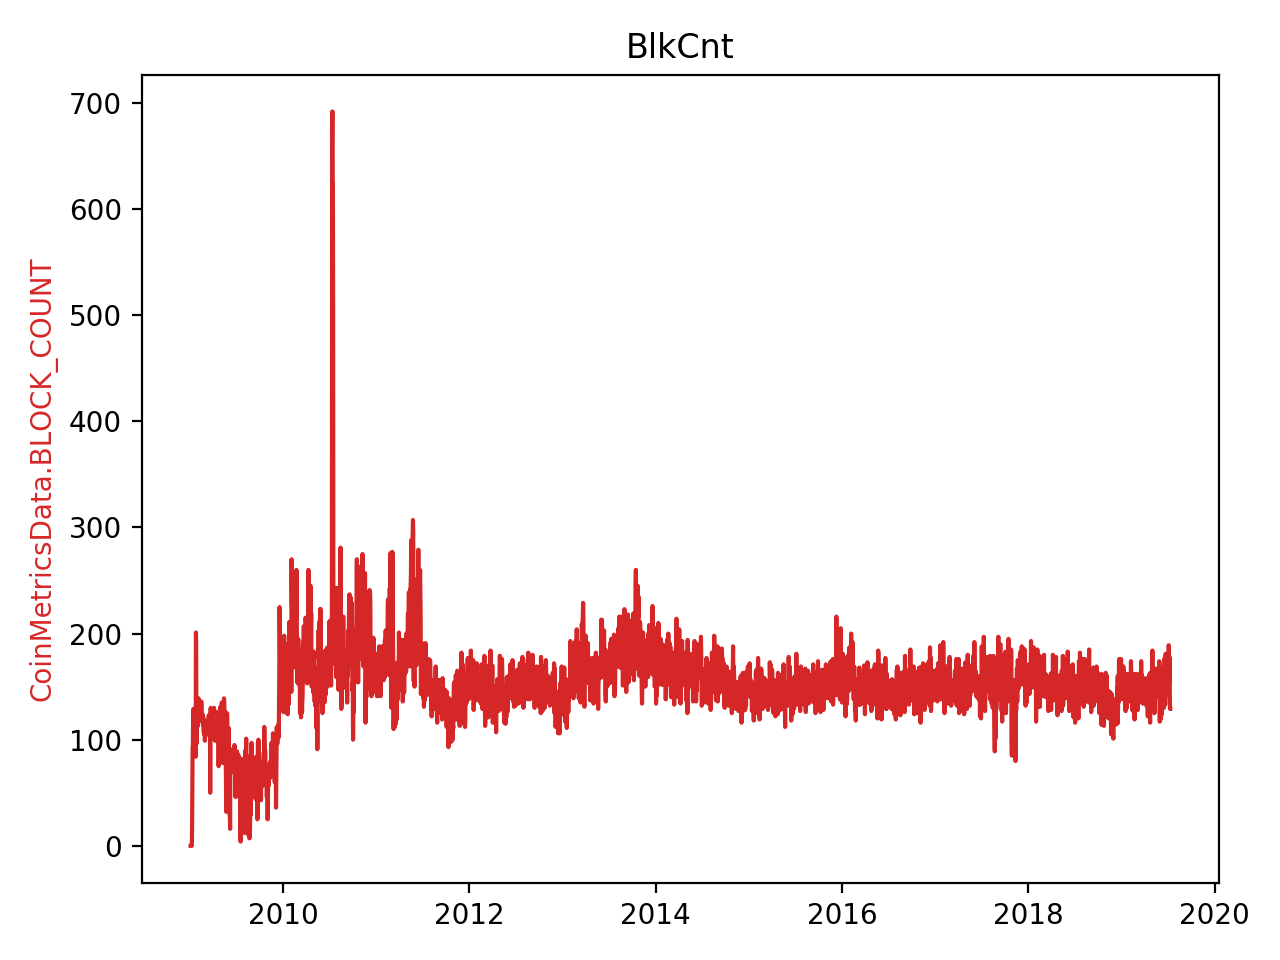

<IPython.core.display.Javascript object>


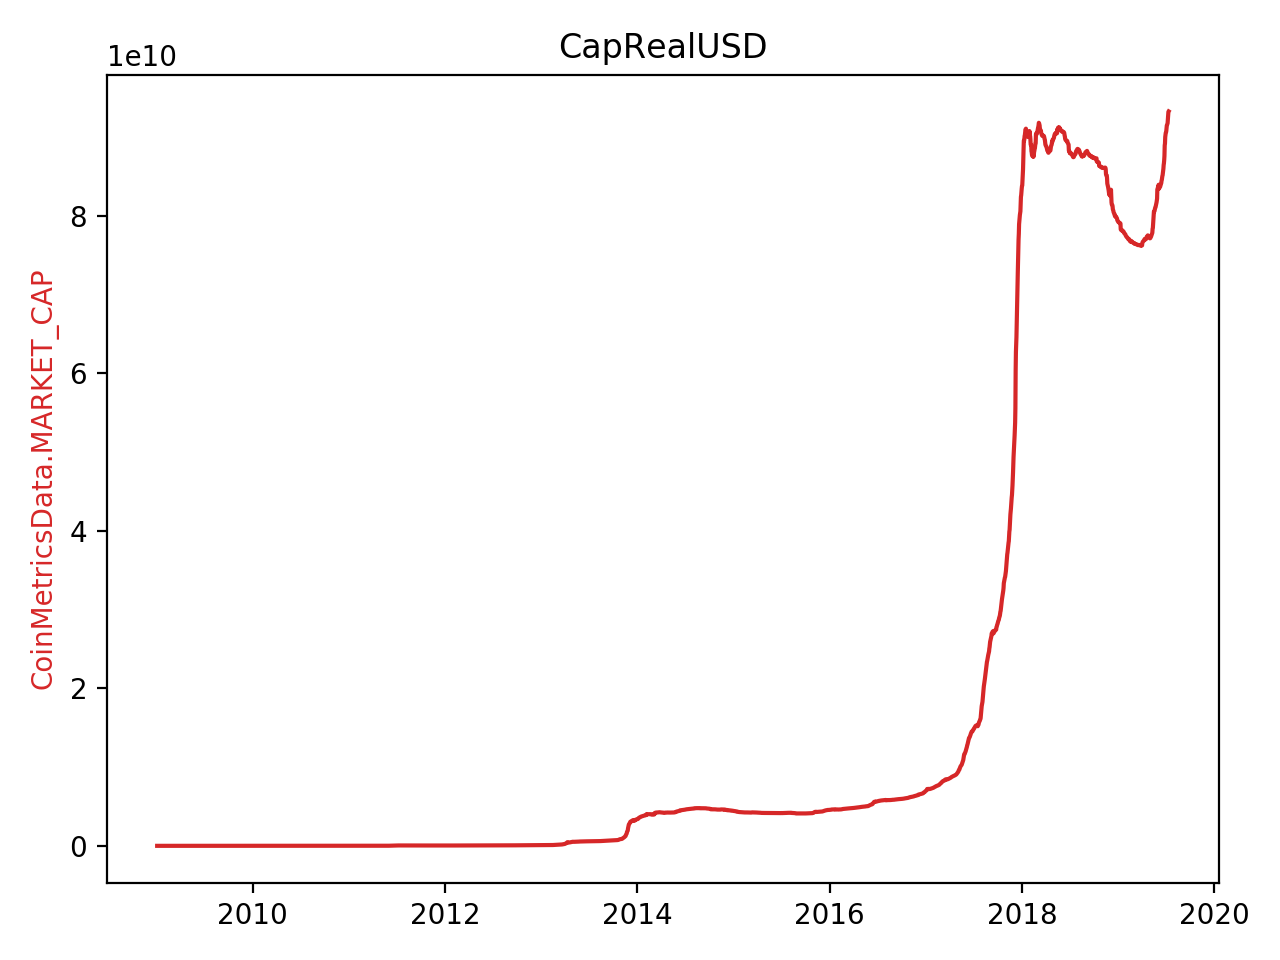

<IPython.core.display.Javascript object>


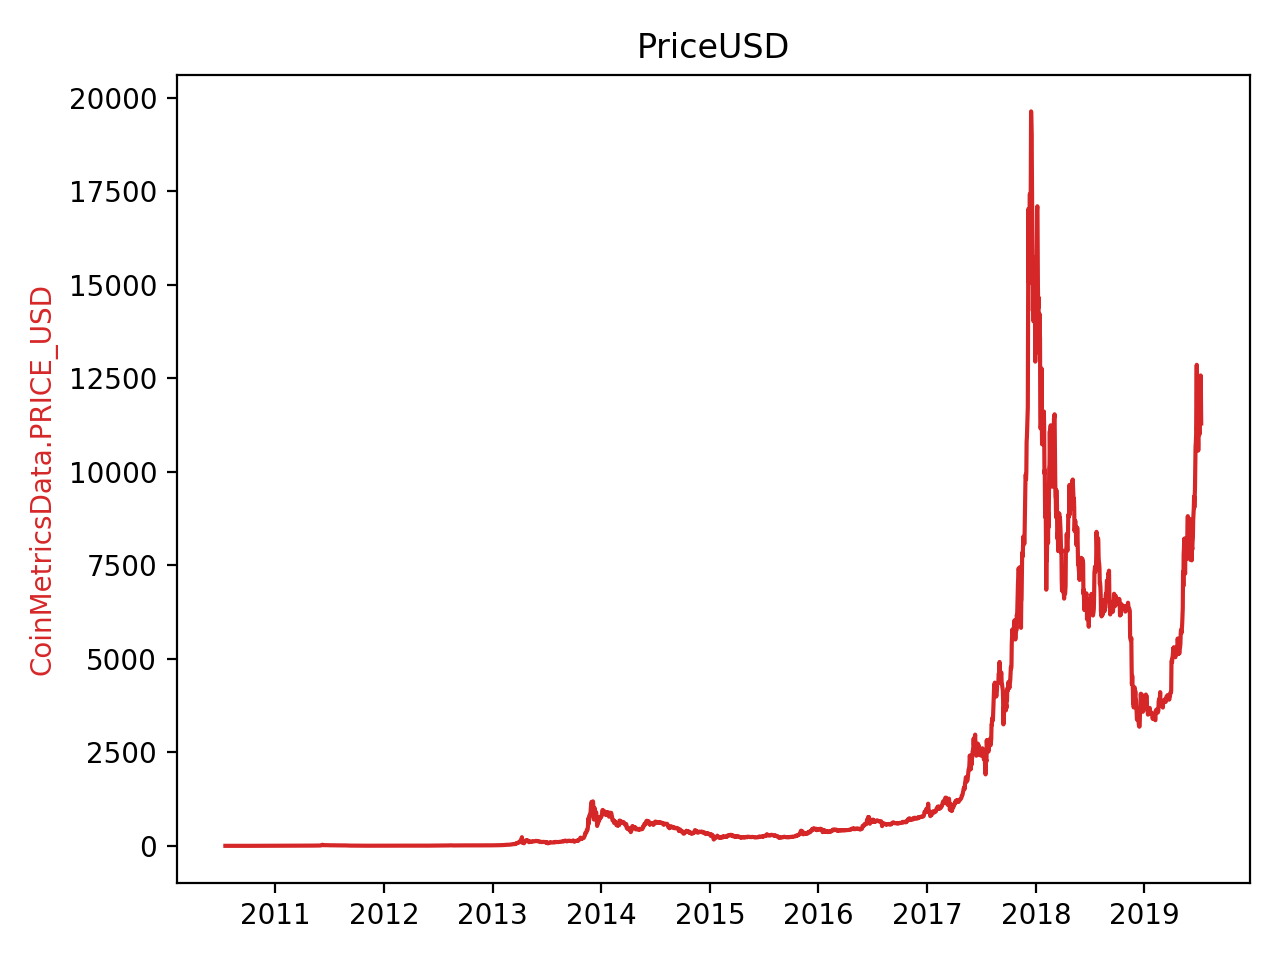

<IPython.core.display.Javascript object>


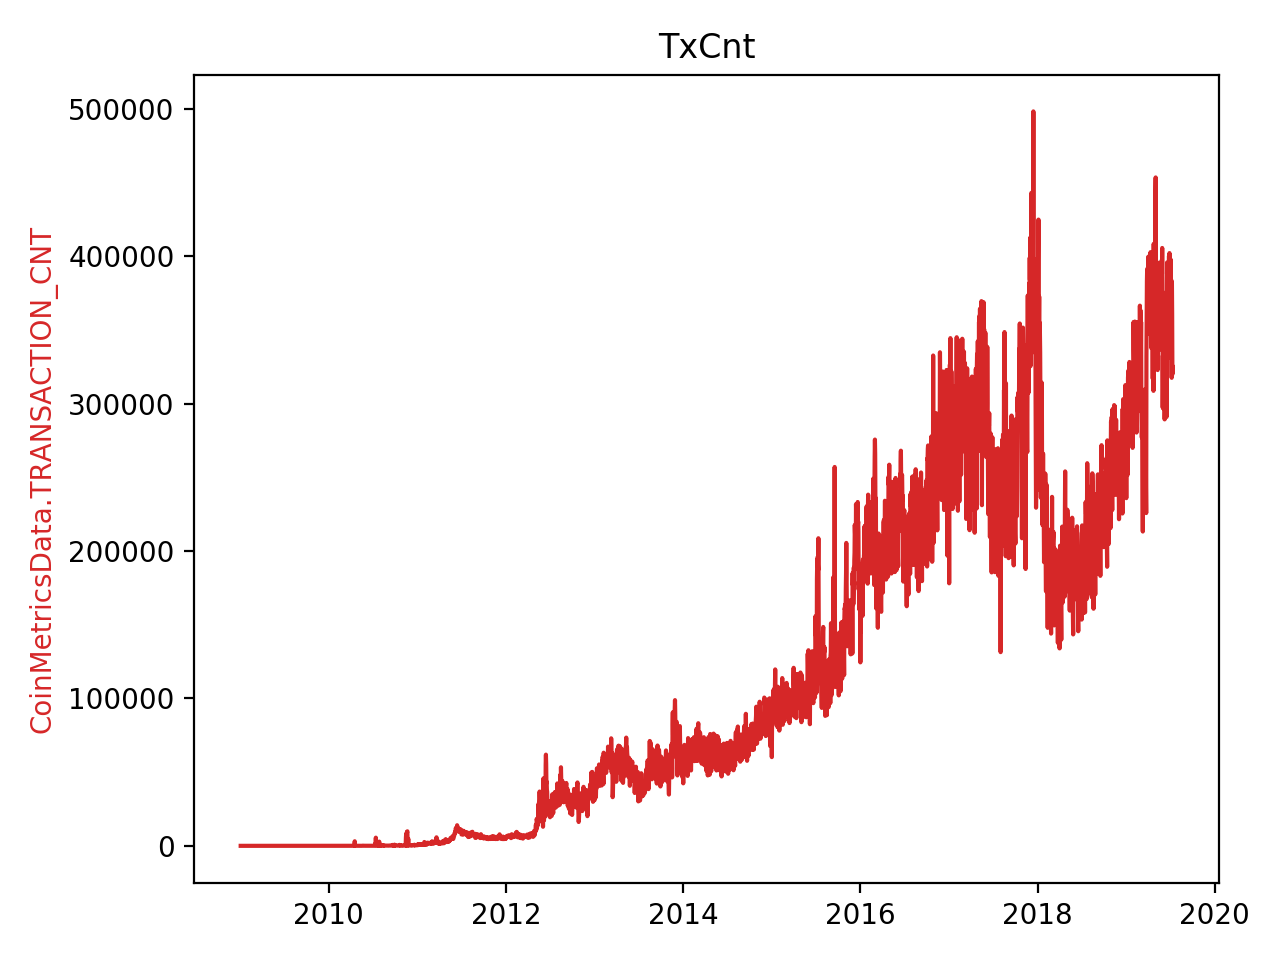

<IPython.core.display.Javascript object>


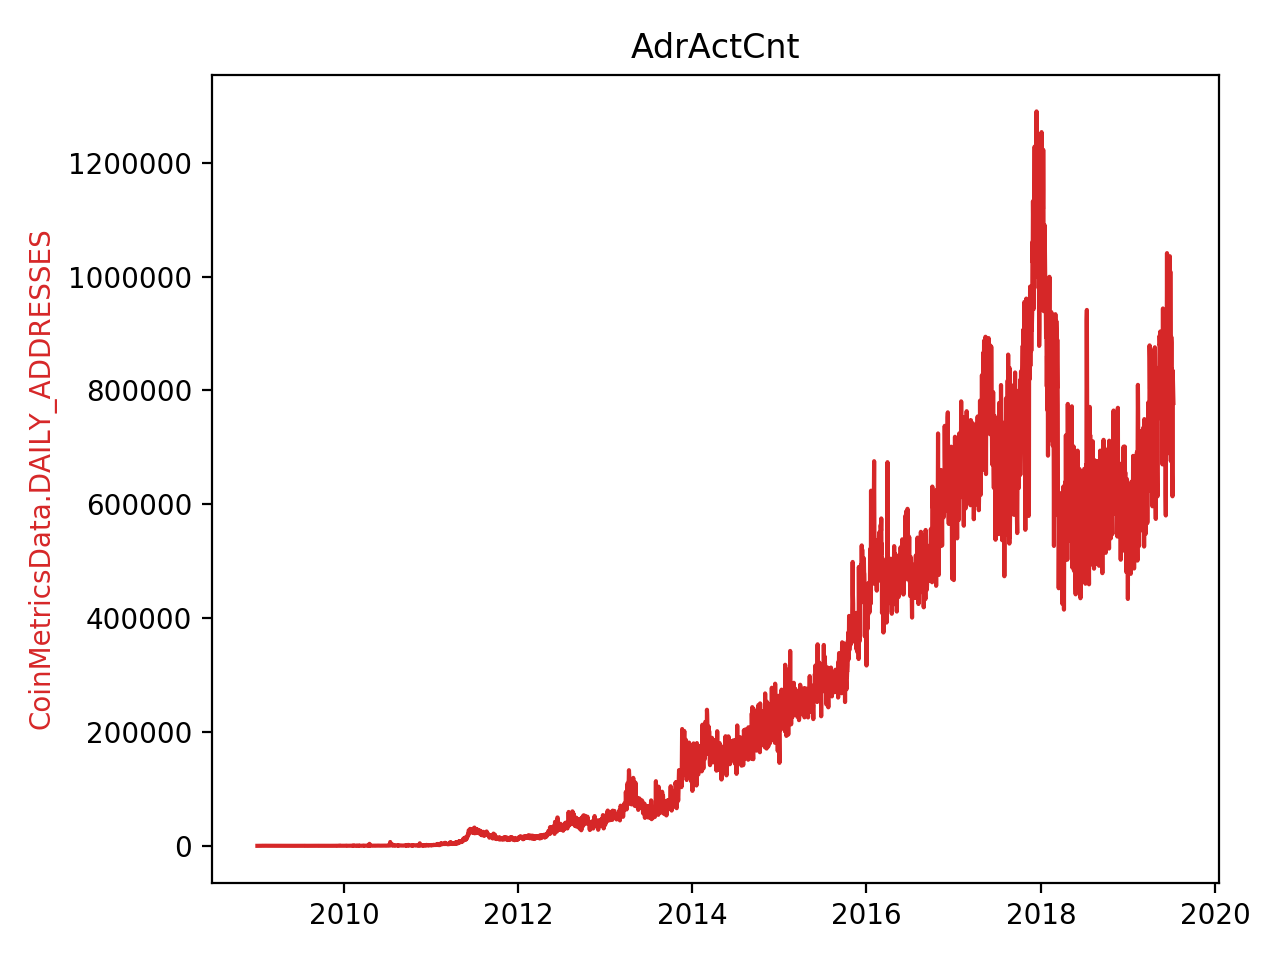

In [13]:
import datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters() # register MatPlotLib date converter
    

# Retrieves from CoinMetrics a metric of a given keyword 'desiredData' (type CoinMetricsData) across all time.
def getAllCoinMetricsData(desiredData):
    data = getCoinMetricsDict(desiredData)['series']
    return {convertTimestamp(singleDay['time'], COIN_METRICS_TIMESTAMP_FORMAT, DESIRED_DATE_FORMAT):float(singleDay['values'][0]) for singleDay in data}

for dataKey in list(CoinMetricsData):
    data = getAllCoinMetricsData(dataKey)

    plotTimeSeries({dataKey: {'x': list(data.keys()), 'y': list(data.values())}}, title=dataKey.value, dateFormat=DESIRED_DATE_FORMAT)

# Aggregate Analysis

## Instantaneous Readings

<IPython.core.display.Javascript object>


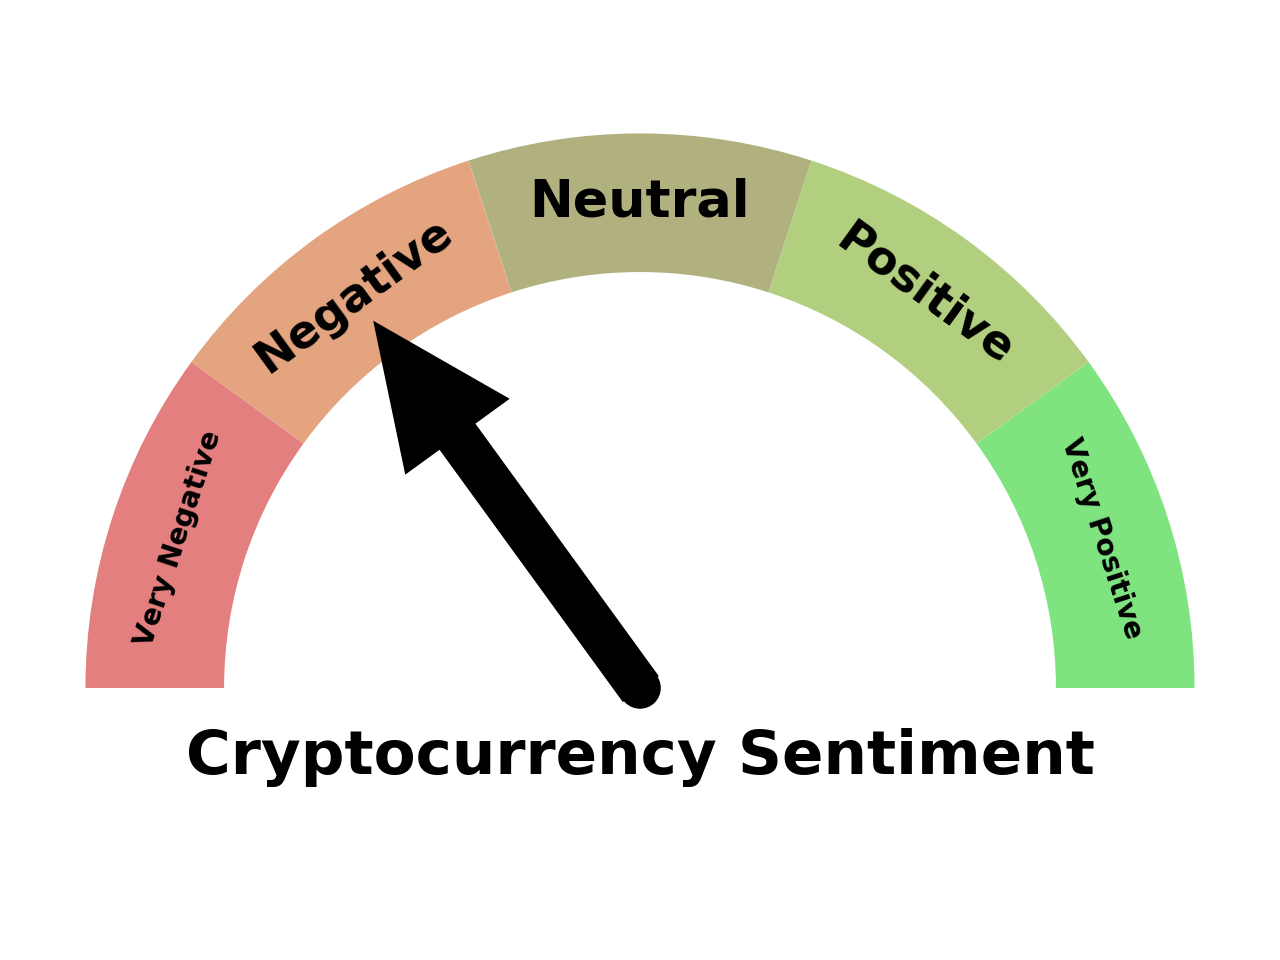

<IPython.core.display.Javascript object>


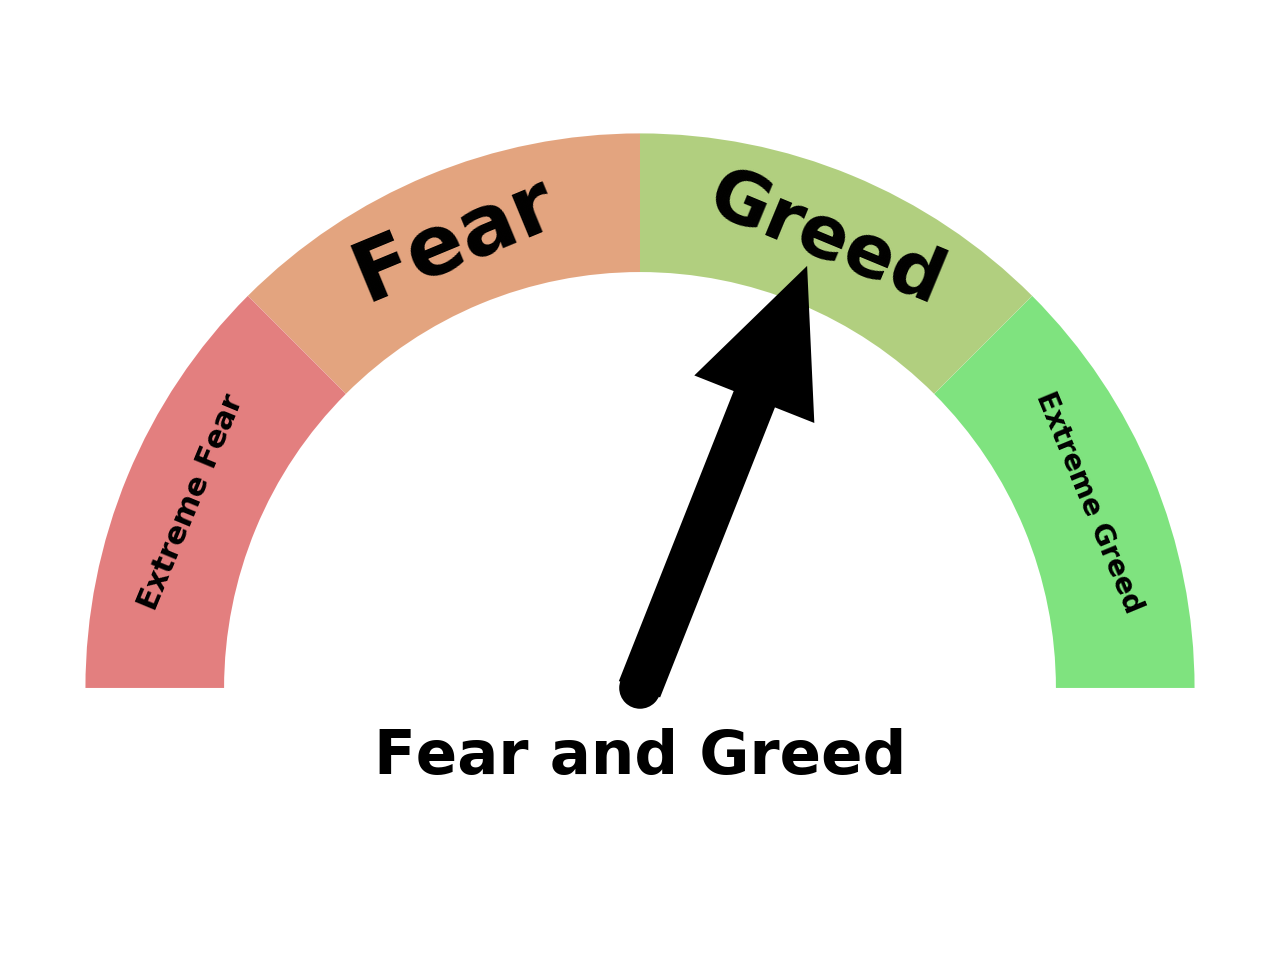

The request failed: Google returned a response with code 400.


<IPython.core.display.Javascript object>


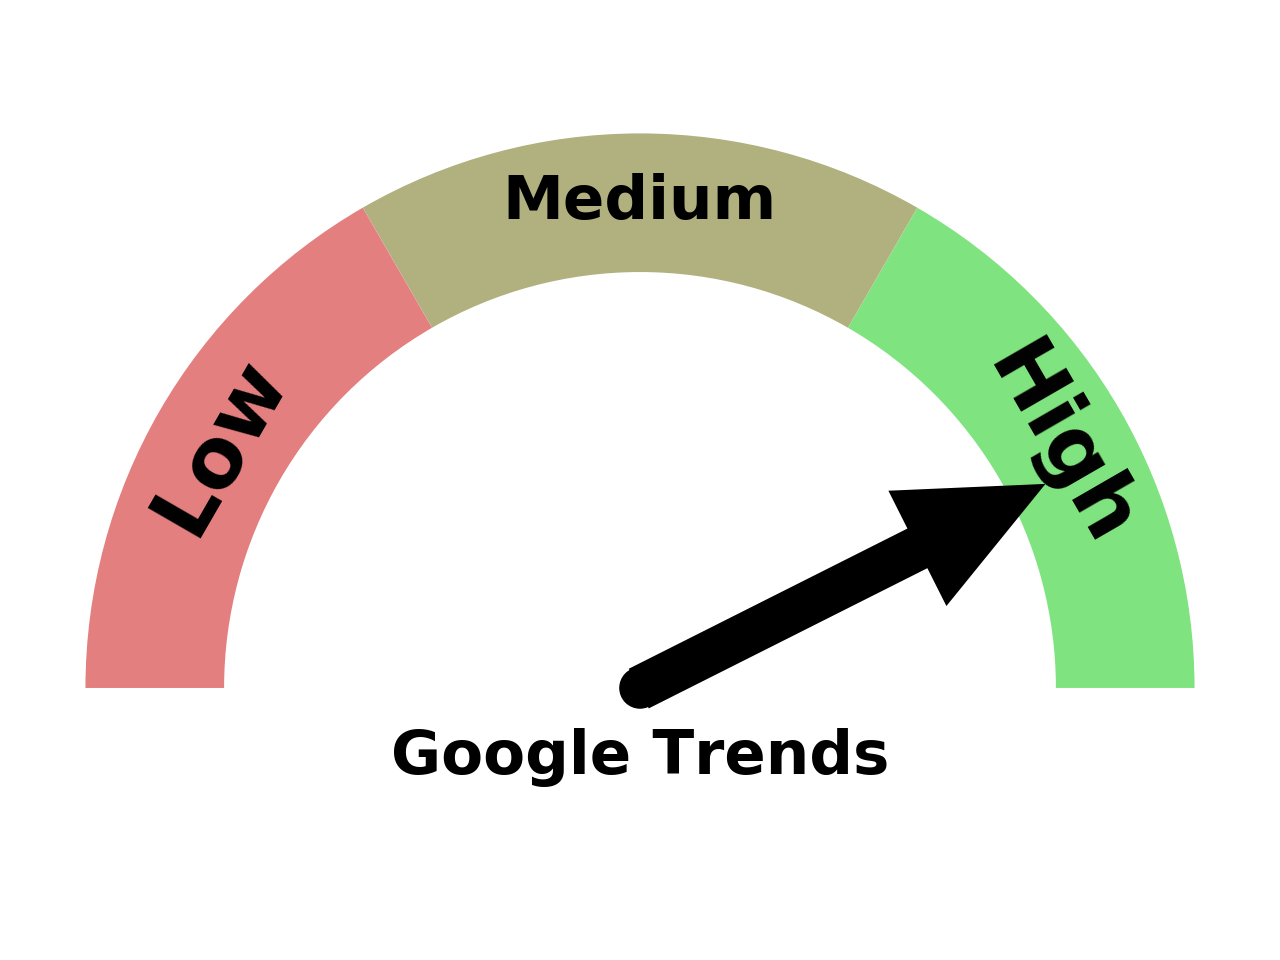

<IPython.core.display.Javascript object>


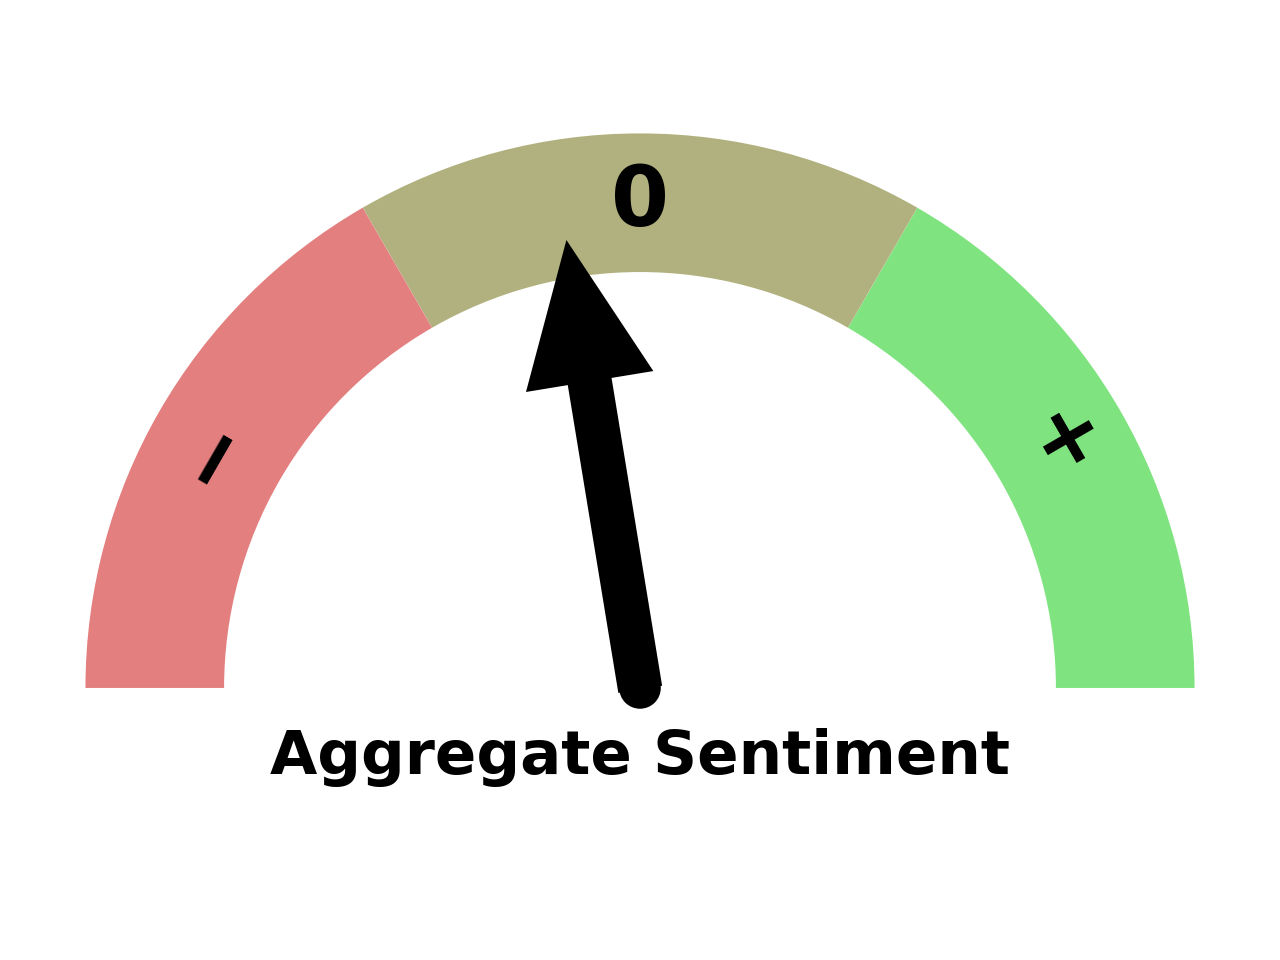

In [29]:
import ipywidgets as widgets
from IPython.display import display

'''
Wraps Jupyter's 'Slider' widget (stored as obj) with a slider description and a boolean keeping track of whether the slider was edited manually or programatically.
'''
class Slider:
    def __init__(self, obj, editedManually, description):
        self.obj = obj
        self.editedManually = editedManually
        self.description = description
        
    def getReading(self):
        return self.obj.value
    
    def setReading(self, newReading):
        self.obj.value = newReading
        
    '''
    Initializes the slider value given the number of sliders in the set. This ensures that all
    sliders will start out with equal values.
    '''
    def initSliderValue(self, numSliders):
        self.setReading(MAX_VAL / numSliders)
    
# Represents a static data reading represented by a single gauge and weighted by a slider.
class DataReading:
    def __init__(self, gauge, slider):
        self.gauge = gauge
        self.slider = slider

# Manages any number of weight sliders, ensuring that they always add to 1.0 regardless of modification.
class SliderManager:
    '''
    Initializes the slider manager. editedFunction is the function to be triggered when a given slider is edited.
    valueDict is the dictionary of values which all the sliders collectively modify. displayedObj is the graph
    which these slider update.
    
    Both valueDict and displayedObj will be passed into editedFunction.
    '''
    def __init__(self, editedFunction, valueDict=None, displayedObj=None):
        self.editedFunction = editedFunction
        self.valueDict = valueDict
        self.displayedObj = displayedObj
        self.slidersDict = {}
        
    # Adds a new slider to the list of observed sliders.
    def addSlider(self, name, slider):
        self.slidersDict[name] = slider
        slider.obj.observe(self.sliderEdited, 'value')
        
    # Retrieves a given slider by its name.
    def getSlider(self, name):
        return self.slidersDict[name]
        
    # Triggers when one of the sliders is edited.
    def sliderEdited(self, change):
        sliders = {data.slider.obj:data.slider for valueType, data in self.valueDict.items()}
        editedSlider = change.owner
        deltaVal = change.new - change.old
        diffPerSlider = deltaVal / (len(sliders) - 1)

        isEditingAnything = False
        for s, sliderProperties in sliders.items():
            isEditingAnything = isEditingAnything or sliderProperties.editedManually # determine whether any value in the sliders dictionary is True

        # If the user manually edited a different slider, then this function should exit early because it was triggered
        # by the programmatic editing of this slider. Prevents a recursive loop.
        if isEditingAnything:
            return False

        sliders[editedSlider].editedManually = True

        i = 0

        uneditedSliders = dict(sliders)
        uneditedSliders.pop(editedSlider)

        # Sort the sliders by the amount of distance they can move (the one with the greatest distance should be edited first).
        # If the edited slider was decreased, all the other sliders have to move up, so the one closest to 0.0 should come last.
        # If the edited slider was increased, all the other sliders have to move down, so the one closest to 1.0 should come last. 
        if deltaVal < 0:
            sortedSliders = sorted(uneditedSliders.items(), key = lambda kv: -kv[0].value)
        else:
            sortedSliders = sorted(uneditedSliders.items(), key = lambda kv: kv[0].value - MAX_VAL)

        for s, editing in sortedSliders:
            origVal = s.value
            s.value = max(0, s.value - diffPerSlider)

            # Only subtracts off the difference which was calculated in the slider (useful when the difference brings the
            # slider value to a number less than zero).
            deltaVal -= (origVal - s.value)
            if i != (len(sortedSliders) - 1): # avoid unnecessary division by zero on the last iteration (value will not be used again)
                diffPerSlider = deltaVal / (len(sortedSliders) - i - 1)
            i += 1
    
        # Reset that a value was edited manually to ensure other sliders can trigger this function.
        sliders[editedSlider].editedManually = False
        self.editedFunction(self.valueDict, self.displayedObj)
        
# Generates a box widget which displays any number of sliders adjacent to their description.
def generateDisplayBox(sliders):
    leftBoxElements = [widgets.Label(slider.description) for slider in sliders]
    rightBoxElements = [slider.obj for slider in sliders]
    return widgets.HBox([widgets.VBox(leftBoxElements), widgets.VBox(rightBoxElements)])

'''
Computes the aggregate sentiment based on a dictionary of values where a given value corresponds to a dictionary containing 
the value's weight (with key 'weight'), the minimum possible value the value can take on (with key 'minVal'), and the 
maximum possible value the value can take on (with key 'maxVal').

Returns a tuple containing (in the following order) the aggregate value, the minimum value for this aggregate, 
and the maximum value for this aggregate.
'''
def computeAggregateSentimentGauge(valueDict):
    aggregateVal = 0
    minVal = 0
    maxVal = 1
    for valueType, data in valueDict.items():
        weight = data.slider.getReading()
        scaledValue = map(data.gauge.currentVal, data.gauge.minVal, data.gauge.maxVal, 0, 1)
        aggregateVal += scaledValue * weight
        
    return (aggregateVal, minVal, maxVal)

'''
Displays the aggregate sentiment meter based on a dictionary of values. See computeAggregateSentiment for a complete
description of this parameter.
'''
def displayAggregateSentimentMeter(valueDict):
    aggregateVal, minVal, maxVal = computeAggregateSentimentGauge(valueDict)
    
    return Gauge(labels=['—','0','+'], 
                 colors=['#c80000', '#646400', '#00c800'], currentVal=aggregateVal, 
                 minVal = minVal,
                 maxVal = maxVal, title='Aggregate Sentiment')

# Updates the corresponding gauge given a new set of values and the existing gauge.
def updateGauge(valueDict, aggregateGauge):
    aggregateVal, minVal, maxVal = computeAggregateSentimentGauge(valueDict)
    
    aggregateGauge.arrow.remove()
    highestAngle = 180
    lowestAngle = 0
    pos = map(aggregateVal, minVal, maxVal, highestAngle, lowestAngle)
    aggregateGauge.arrow = aggregateGauge.ax.arrow(0, 0, 0.225 * np.cos(np.radians(pos)), 0.225 * np.sin(np.radians(pos)),
        width=0.03, head_width=0.09, head_length=0.1, fc='k', ec='k')
    
    aggregateGauge.fig.canvas.draw_idle()
    
MAX_VAL = 1.0
STEP = 0.01

sentimentGauge = displaySentimentTxt(getCNNText("https://www.cnn.com/2019/06/21/investing/bitcoin-price-increase/index.html"))
fngGauge = displayFearAndGreedDate(datetime.datetime.now())

trendsData = getTrendsDataDate("Bitcoin", datetime.datetime.now())
trendsGauge = displayNeutralGauge(trendsData, 0, 100, "Google Trends")        

valueDict = {'sentiment': DataReading(gauge=sentimentGauge,
                                      slider=Slider(obj=widgets.FloatSlider(min=0.0, max=MAX_VAL, step=STEP, value=0.0),
                                                    editedManually=False,
                                                    description="NLP Weight")),
             'fearAndGreed': DataReading(gauge=fngGauge,
                                         slider=Slider(obj=widgets.FloatSlider(min=0.0, max=MAX_VAL, step=STEP, value=0.0),
                                                       editedManually=False,
                                                      description="Fear and Greed Weight")),
             'trends': DataReading(gauge=trendsGauge,
                                   slider=Slider(obj=widgets.FloatSlider(min=0.0, max=MAX_VAL, step=STEP, value=0.0),
                                                       editedManually=False,
            
                                                 description="Trends Weight"))}
for valueType, data in valueDict.items():
    data.slider.initSliderValue(len(valueDict))

aggregateGauge = displayAggregateSentimentMeter(valueDict)

sliderManager = SliderManager(editedFunction=updateGauge, valueDict=valueDict, displayedObj=aggregateGauge)

for valueType, data in valueDict.items():
    sliderManager.addSlider(name=valueType, slider=data.slider)
display(generateDisplayBox([data.slider for key, data in valueDict.items()]))

## Historical Reading

<IPython.core.display.Javascript object>


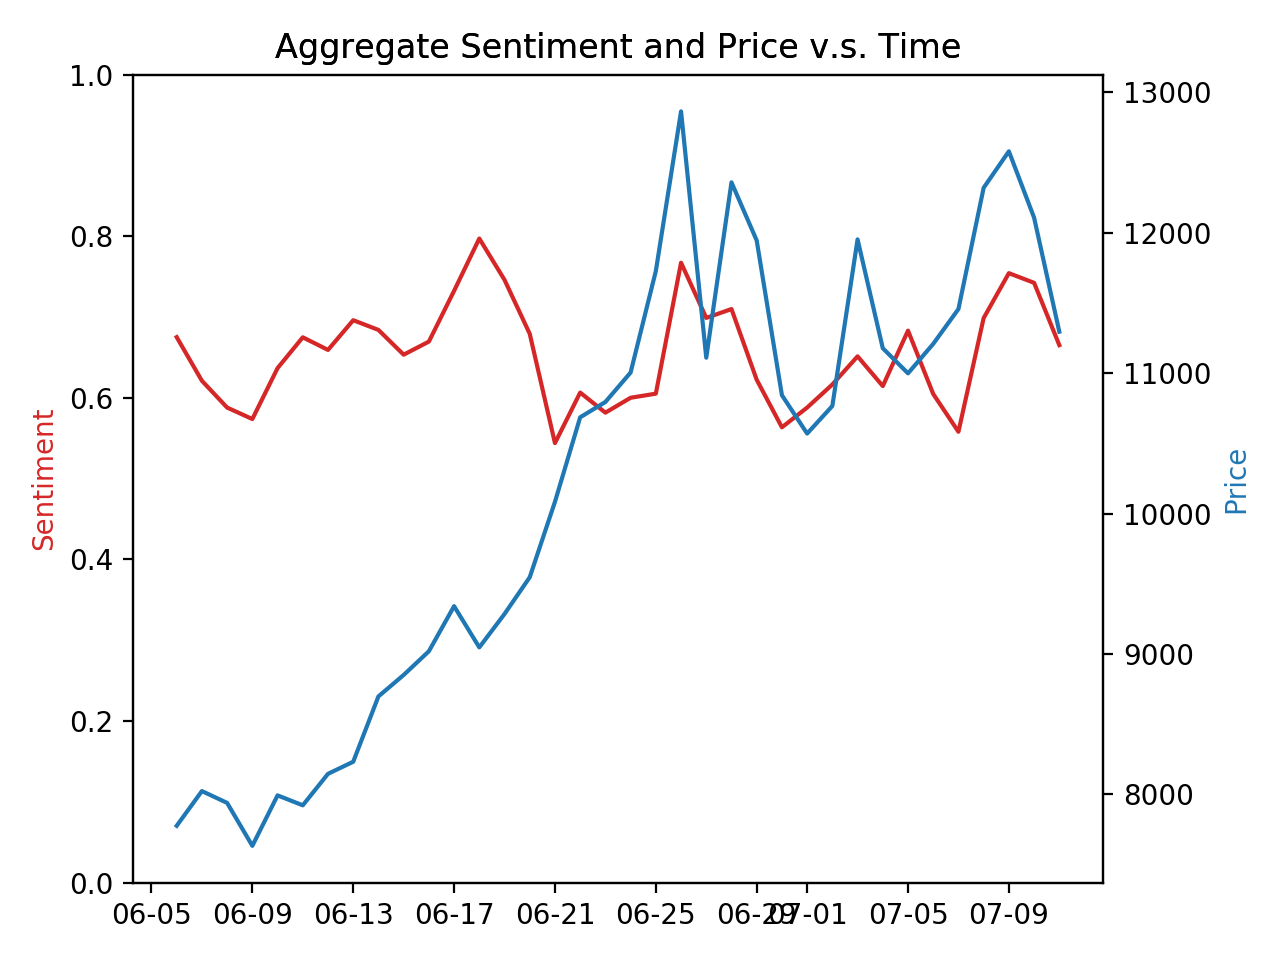

In [15]:
import numpy
import datetime

'''
Represents a piece of data with several values over time. 'values' is a dictionary with the date as the key
and the corresponding value on that date as the value. 'slider' is the slider modifying the weight of this reading.
'''
class HistoricalDataReading:
    def __init__(self, values, slider, minVal=None, maxVal=None):
        self.values = values
        self.slider = slider
        
        # If no range is specified, manually compute the range using all given values.
        if minVal == None or maxVal == None:
            minVal = values[min(values, key=lambda key: values[key])]
            maxVal = values[max(values, key=lambda key: values[key])]
            
        self.minVal = minVal
        self.maxVal = maxVal
        
'''
Given the dictionary of values to be used (value type as key and HistoricalDataReading as value), 
determines the range of dates which guarantees that every value in the dictionary will be included over every date. 
Assumes that there are no gaps between dates (ie: 2019-07-09 followed by 2019-07-11).
'''
def getDateRange(valueDict):
    minDateArr = [numpy.min([datetime.datetime.strptime(date, DESIRED_DATE_FORMAT) 
                             for date in historicalValues.values]) 
                  for valueType, historicalValues in valueDict.items()]
    earliestDate = numpy.max(minDateArr) # start at the date which guarantees that all values will be included
    
    maxDateArr = [numpy.max([datetime.datetime.strptime(date, DESIRED_DATE_FORMAT) 
                             for date in historicalValues.values]) 
                  for valueType, historicalValues in valueDict.items()]
    latestDate = numpy.min(maxDateArr) # end at the date which guarantees that all values will be included
    
    return (earliestDate, latestDate)

'''
Given a dictionary of values (value type as key and HistoricalDataReading as value), 
computes the weighted historical sentiment with the date as the key and the historical sentiment on that date as the value.
'''
def getHistoricalSentiment(valueDict):
    sentimentByDate = {}
    
    earliestDate, latestDate = getDateRange(valueDict)
    
    for key, historicalReading in valueDict.items():
        for date, value in historicalReading.values.items():
            convertedDate = datetime.datetime.strptime(date, DESIRED_DATE_FORMAT)
            if convertedDate >= earliestDate and convertedDate <= latestDate:
                weightedVal = map(value, historicalReading.minVal, historicalReading.maxVal, 0, 1) * historicalReading.slider.getReading()
                if not date in sentimentByDate:
                    sentimentByDate[date] = weightedVal
                else:
                    sentimentByDate[date] += weightedVal
        
    return sentimentByDate

'''
Updates an existing graph given a dictionary of values 'valueDict' (value type as key and HistoricalDataReading as value).
If there is no existing graph, generates a new one based on this dictionary. Overlays any additional data specified
as keyworded-arguments with date as key and the value on that date as the value.

The values within valueDict are the ones which can be modified in the future. All additional values as keyworded-arguments
will remain static when plotted and cannot be removed.
'''
def updateGraph(valueDict, existingGraph=None, **kwargs):
    aggregateByDate = getHistoricalSentiment(valueDict)
    
    if existingGraph == None:
        fig, ax = plt.subplots()
        existingGraph = TimeSeries(fig=fig, ax=ax)
    else:
        existingGraph.ax.clear()
    xyDict = {'Sentiment': {'x': [date for date in aggregateByDate], 
                            'y': [value for date, value in aggregateByDate.items()]}}
    for key in kwargs:
        dataDict = kwargs[key]
        xyDict[key] = {'x': list(dataDict.keys()), 'y': list(dataDict.values())}
        
    return plotTimeSeries(xyDict=xyDict, dateFormat=DESIRED_DATE_FORMAT, graphDateFormat="%m-%d", 
                          existingGraph=existingGraph, yMin=0, yMax=1, 
                          title = "Aggregate Sentiment and Price v.s. Time")

valueDict = {'fearAndGreed': HistoricalDataReading(values=getAllFearAndGreed(), 
                              slider=Slider(obj=widgets.FloatSlider(min=0.0, max=MAX_VAL, step=STEP, value=0.0),
                                                      editedManually=False,
                                                      description="Fear and Greed Weight"), minVal = MIN_FEAR_AND_GREED,
                                                  maxVal = MAX_FEAR_AND_GREED),
             'trends': HistoricalDataReading(values=getTrendsDataByDay("Bitcoin", datetime.datetime.now() - datetime.timedelta(days=35), datetime.datetime.now()), 
                              slider=Slider(obj=widgets.FloatSlider(min=0.0, max=MAX_VAL, step=STEP, value=0.0),
                                                       editedManually=False,
                                                      description="Trends Weight")),
             'addresses': HistoricalDataReading(values=getAllCoinMetricsData(CoinMetricsData.DAILY_ADDRESSES),
                                               slider=Slider(obj=widgets.FloatSlider(min=0.0, max=MAX_VAL, step=STEP, value=0.0),
                                                       editedManually=False,
                                                      description="Addresses Weight")),
             'transactions': HistoricalDataReading(values=getAllCoinMetricsData(CoinMetricsData.TRANSACTION_CNT),
                                               slider=Slider(obj=widgets.FloatSlider(min=0.0, max=MAX_VAL, step=STEP, value=0.0),
                                                       editedManually=False,
                                                      description="Transaction Weight"))}


earliestDate, latestDate = getDateRange(valueDict)
priceData = getAllCoinMetricsData(CoinMetricsData.PRICE_USD)

newPriceData = {}
# Ensures that only elements within the computed date range can be added.
for date, val in priceData.items():
    convertedDate = datetime.datetime.strptime(date, DESIRED_DATE_FORMAT) 
    if convertedDate >= earliestDate and convertedDate <= latestDate:
        newPriceData[date] = val 

for valueType, data in valueDict.items():
    data.slider.initSliderValue(len(valueDict))

graph = updateGraph(valueDict, Price=newPriceData)

sliderManager = SliderManager(editedFunction=updateGraph, valueDict=valueDict, displayedObj=graph)
for valueType, data in valueDict.items():
    sliderManager.addSlider(name=valueType, slider=data.slider)

display(generateDisplayBox([data.slider for key, data in valueDict.items()]))

# Wrap-Up

In [16]:
exec('kill $(lsof -ti tcp:9000)')